<a href="https://colab.research.google.com/github/alexdrane/GaussianHeartRate/blob/main/Gaussian_Heart_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tinygp
!pip install jaxopt
!pip install git+https://github.com/handley-lab/blackjax@nested_sampling
!pip install mpi4py corner jaxopt
!pip install corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 4.7 MB/s eta 0:00:00
  Cloning https://github.com/handley-lab/blackjax (to revision nested_sampling) to /tmp/pip-req-build-9bkxivod
  Running command git clone --filter=blob:none --quiet https://github.com/handley-lab/blackjax /tmp/pip-req-build-9bkxivod
  Resolved https://github.com/handley-lab/blackjax to commit 95e93ed93e726b95143b2f4a9582888621625f52
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.9 MB/s eta 0:00:00
  Created wheel for blackjax: filename=blackjax-0.1.dev717+g95e93ed93-py3-none-any.whl size=4672732 sha256=eccfdc863b6605f3c9fa93a541

In [ ]:
!pip install intervalsicu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pluggy
    Found existing installation: pluggy 1.6.0
    Uninstalling pluggy-1.6.0:
      Successfully uninstalled pluggy-1.6.0
  Attempting uninstall: pytest
    Found existing installation: pytest 8.4.2
    Uninstalling pytest-8.4.2:
      Successfully uninstalled pytest-8.4.2


In [ ]:
import os
import datetime
from datetime import date
# from intervalsicu import Intervals
import requests
import pprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Intervals.icu Import**

In [ ]:
ATHLETE_ID = os.getenv("INTERVALS_ATHLETE_ID", "i347906")
API_KEY = os.getenv("INTERVALS_API_KEY", "2md7ofnfisjyaqe7uoeujowz")


In [ ]:
svc = Intervals("i347906","2md7ofnfisjyaqe7ioeujowz", strict=False)

start = date.fromisoformat("2024-07-12")
wellness = svc.wellness(start)
wellness = svc.wellness_put(wellness)
pprint.pprint(wellness)

{'abdomen': None,
 'atl': 13.479111,
 'atlLoad': 56.0,
 'avgSleepingHR': None,
 'baevskySI': None,
 'bloodGlucose': None,
 'bodyFat': None,
 'comments': None,
 'ctl': 16.135424,
 'ctlLoad': 56.0,
 'diastolic': None,
 'fatigue': None,
 'hrv': None,
 'hrvSDNN': None,
 'hydration': None,
 'hydrationVolume': None,
 'id': '2024-07-12',
 'injury': None,
 'kcalConsumed': None,
 'lactate': None,
 'locked': None,
 'menstrualPhase': None,
 'menstrualPhasePredicted': None,
 'mood': None,
 'motivation': None,
 'rampRate': 0.3991413,
 'readiness': None,
 'respiration': None,
 'restingHR': 56,
 'sleepQuality': None,
 'sleepScore': None,
 'sleepSecs': 16560,
 'soreness': None,
 'spO2': None,
 'sportInfo': [{'eftp': None, 'pMax': None, 'type': 'Ride', 'wPrime': None}],
 'steps': 10387,
 'stress': None,
 'systolic': None,
 'tempRestingHR': False,
 'tempWeight': False,
 'updated': '2025-11-19T19:53:18.373+00:00',
 'vo2max': 52.0,
 'weight': 85.0}


In [ ]:
START_DATE = date(2024, 3, 5)
END_DATE = date.today()

dates = []
resting_hr = []




current_date = START_DATE
while current_date <= END_DATE:
    try:
        wellness = svc.wellness(current_date)
        if wellness.get('restingHR'):
            dates.append(current_date)
            resting_hr.append(wellness['restingHR'])
            print(f"Date: {current_date}, Resting HR: {wellness['restingHR']}")
    except Exception as e:
        print(f"Could not fetch data for {current_date}: {e}")
    current_date += datetime.timedelta(days=1)




Could not fetch data for 2024-03-05: name 'svc' is not defined
Could not fetch data for 2024-03-06: name 'svc' is not defined
Could not fetch data for 2024-03-07: name 'svc' is not defined
Could not fetch data for 2024-03-08: name 'svc' is not defined
Could not fetch data for 2024-03-09: name 'svc' is not defined
Could not fetch data for 2024-03-10: name 'svc' is not defined
Could not fetch data for 2024-03-11: name 'svc' is not defined
Could not fetch data for 2024-03-12: name 'svc' is not defined
Could not fetch data for 2024-03-13: name 'svc' is not defined
Could not fetch data for 2024-03-14: name 'svc' is not defined
Could not fetch data for 2024-03-15: name 'svc' is not defined
Could not fetch data for 2024-03-16: name 'svc' is not defined
Could not fetch data for 2024-03-17: name 'svc' is not defined
Could not fetch data for 2024-03-18: name 'svc' is not defined
Could not fetch data for 2024-03-19: name 'svc' is not defined
Could not fetch data for 2024-03-20: name 'svc' is not 

In [ ]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.DataFrame({'Date': dates, 'restingHR': resting_hr})
df.to_csv(path, index=False)
print(f"Saved to {path}")


Saved to /content/drive/My Drive/intervals/biometrics.csv


## **Start Here for CSV import**

In [ ]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.read_csv(path)
dates = pd.to_datetime(df['Date']).tolist()
resting_hr = df['restingHR'].tolist()
# dates = dates[40:]
# resting_hr = resting_hr[40:]
dates = dates[40:240]
resting_hr = resting_hr[40:240]
print(dates)
print(resting_hr)

[Timestamp('2024-05-07 00:00:00'), Timestamp('2024-05-08 00:00:00'), Timestamp('2024-05-09 00:00:00'), Timestamp('2024-05-10 00:00:00'), Timestamp('2024-05-11 00:00:00'), Timestamp('2024-05-12 00:00:00'), Timestamp('2024-05-13 00:00:00'), Timestamp('2024-05-14 00:00:00'), Timestamp('2024-05-15 00:00:00'), Timestamp('2024-05-16 00:00:00'), Timestamp('2024-05-17 00:00:00'), Timestamp('2024-05-18 00:00:00'), Timestamp('2024-05-19 00:00:00'), Timestamp('2024-05-20 00:00:00'), Timestamp('2024-05-21 00:00:00'), Timestamp('2024-05-22 00:00:00'), Timestamp('2024-05-23 00:00:00'), Timestamp('2024-05-24 00:00:00'), Timestamp('2024-05-25 00:00:00'), Timestamp('2024-05-26 00:00:00'), Timestamp('2024-05-27 00:00:00'), Timestamp('2024-05-28 00:00:00'), Timestamp('2024-05-29 00:00:00'), Timestamp('2024-05-30 00:00:00'), Timestamp('2024-05-31 00:00:00'), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-06-02 00:00:00'), Timestamp('2024-06-03 00:00:00'), Timestamp('2024-06-04 00:00:00'), Timestamp('20

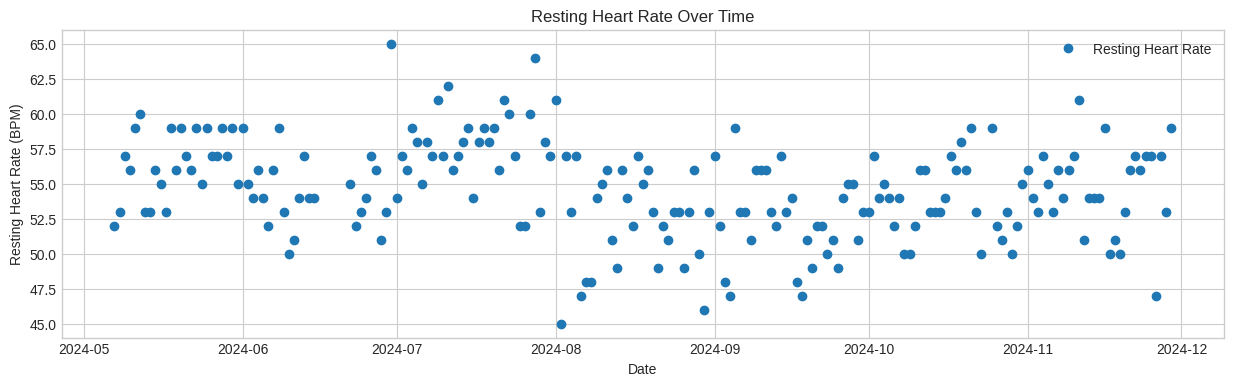

In [ ]:
import matplotlib.pyplot as plt
if dates:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 4))

    ax.plot(dates, resting_hr, 'o', label='Resting Heart Rate')

    # Formatting the plot
    ax.set_title('Resting Heart Rate Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Resting Heart Rate (BPM)')
    ax.legend()
    ax.grid(True)

    # Improve date formatting on the x-axis

    plt.show()
else:
    print("No resting heart rate data found to plot.")

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import jit, vmap, random, value_and_grad, lax
from jax.scipy.special import logsumexp, gammaln
from jax.flatten_util import ravel_pytree
import tinygp
import blackjax
from functools import partial
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import optax
import numpy as np


# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)
jax.clear_caches()

# ==========================================
# 1. SETUP: DATA & MODEL
# ==========================================

rng_key = jax.random.PRNGKey(42)
# X = jnp.linspace(0, 600, 100) # Days
# true_trend = 55 + 0.01 * X
# true_periodic = 5.0 * jnp.sin(2 * jnp.pi * X / 7.0)
# y = true_trend + true_periodic + 2.0 * jax.random.normal(rng_key, X.shape)

start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
print(f"Data points: {len(X)}")


y0, y1, x1 = y[0], y[-1], X[-1]

def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(jnp.exp(params["log_scale_trend"]))
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]), gamma=jnp.exp(params["log_gamma_periodic"]))
    kernel = kernel_trend + kernel_periodic

    return tinygp.GaussianProcess(kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean = params['mean'])

prior_params = {
    "log_jitter": (-1.0, 1.0), "log_amp_trend": (0.0, 2.0), "log_scale_trend": (2.0, 2.0),
    "log_amp_periodic": (0.0, 2.0), "log_period": (2.0, 2.0), "log_gamma_periodic": (0.0, 2.0), "mean": (0.0, 100.0)
}

init_dummy = {k: v[0] for k, v in prior_params.items()}
flat_init, unravel_fn = ravel_pytree(init_dummy)
D = len(flat_init)

# ==========================================
# 2. LOG PROBS
# ==========================================
t0 = time.time()
@jit
def log_likelihood_flat(theta_flat):
    params = unravel_fn(theta_flat)
    gp = build_gp(params, X)
    return gp.log_probability(y)

@jit
def log_prior_flat(theta_flat):
    params = unravel_fn(theta_flat)
    logp = 0.0
    for k, (loc, scale) in prior_params.items():
        logp += norm.logpdf(params[k], loc=loc, scale=scale)
    return logp

@jit
def log_posterior_total(theta):
    return log_likelihood_flat(theta) + log_prior_flat(theta)

# ==========================================
# 3. RUN 1: BASELINE
# ==========================================
print("--- STARTING RUN 1: BASELINE ---")

n_live = 500
num_delete = n_live // 2
ns_algo = blackjax.nss(
    logprior_fn=log_prior_flat, loglikelihood_fn=log_likelihood_flat,
    num_delete=num_delete, num_inner_steps=D * 2
)

# Init Particles
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_live):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
              for i, (k, (loc, scale)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles = jnp.stack(init_particles_list)

state = ns_algo.init(initial_particles, log_likelihood_flat)
step_fn = jit(ns_algo.step)

dead_points_list = []
dead_logL_list = [] # Tracker for likelihoods

with tqdm.tqdm(desc="Baseline Run", unit=" dead") as pbar:
    while (state.logZ_live - state.logZ) > -3:
        rng_key, step_key = random.split(rng_key)
        state, info = step_fn(step_key, state)

        n_dead_step = len(info.particles)
        pbar.update(n_dead_step)

        dead_points_list.append(info.particles)
        # FIX: Attribute is 'loglikelihood' (no underscore)
        dead_logL_list.append(info.loglikelihood)

t_base = time.time() - t0
logZ_base = state.logZ
print(f"Baseline LogZ: {logZ_base:.2f} | Time: {t_base:.2f}s")

# Posterior for fitting
posterior_samples = jnp.concatenate(dead_points_list)
posterior_samples = posterior_samples[int(len(posterior_samples)*0.5):]

# ==========================================
# 4. FITTING PHASE
# ==========================================
print("\n--- FITTING REPARTITIONED PRIOR ---")
n_live = 500
n_sample = 2000
t_opt_start = time.time()
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_sample):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
              for i, (k, (loc, scale)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles = jnp.stack(init_particles_list)


# --- Definitions ---
def find_modes_parallel(rng, samples, n_candidates=2000):
    idx = random.choice(rng, len(samples), shape=(n_candidates,), replace=False)
    starts = samples[idx]
    optimizer = optax.adam(0.1)

    def optimize_single(start_pt):
        state = optimizer.init(start_pt)
        def step(c, _):
            p, s = c
            grads = jax.grad(lambda x: -log_posterior_total(x))(p)
            updates, s = optimizer.update(grads, s)
            return (optax.apply_updates(p, updates), s), None
        (final_pt, _), _ = lax.scan(step, (start_pt, state), None, length=100)
        return final_pt

    candidates = vmap(optimize_single)(starts)

    cands_np = np.array(candidates)
    unique_modes = []
    scores = vmap(log_posterior_total)(candidates)
    sorted_idx = np.argsort(np.array(scores))[::-1]
    cands_np = cands_np[sorted_idx]

    for c in cands_np:
        if len(unique_modes) == 0: unique_modes.append(c)
        else:
            dists = np.linalg.norm(np.array(unique_modes) - c, axis=1)
            if np.all(dists > 1.0): unique_modes.append(c)
    return jnp.array(unique_modes)

def make_valid_precision(H):
    vals, vecs = jnp.linalg.eigh(-H)
    vals = jnp.maximum(vals, 1e-4)
    # Fix Aspect Ratio & Inflate
    max_curv = jnp.min(vals) * 10.0
    vals = jnp.minimum(vals, max_curv)
    vals = vals / 2.0
    return vecs @ jnp.diag(vals) @ vecs.T

@jit
def fit_tails_fast(samples, modes, Ps):
    k = len(modes)
    def compute_dist(mu, P):
        diff = samples - mu
        return jnp.sum((diff @ P) * diff, axis=1)
    Deltas = vmap(compute_dist)(modes, Ps)
    _, log_dets = jnp.linalg.slogdet(Ps)
    init_params = {'w': jnp.zeros(k), 'nu': jnp.zeros(k)}
    optimizer = optax.adam(0.1)
    opt_state = optimizer.init(init_params)
    def loss_fn(p):
        w = jax.nn.softmax(p['w'])
        nu = 1.0 + 29.0 * jax.nn.sigmoid(p['nu'])
        log_norm = gammaln((nu+D)/2) - gammaln(nu/2) - 0.5*D*jnp.log(nu*jnp.pi) + 0.5*log_dets
        log_term = -0.5*(nu[:,None]+D) * jnp.log(1.0 + Deltas / nu[:,None])
        log_probs = log_norm[:,None] + log_term + jnp.log(w[:,None])
        return -jnp.mean(logsumexp(log_probs, axis=0))
    def step(carry, _):
        p, s = carry
        l, g = value_and_grad(loss_fn)(p)
        u, s = optimizer.update(g, s)
        return (optax.apply_updates(p, u), s), None
    (final_p, _), _ = lax.scan(step, (init_params, opt_state), None, length=500)
    return jax.nn.softmax(final_p['w']), 1.0 + 29.0 * jax.nn.sigmoid(final_p['nu'])

@partial(jit, static_argnums=(1,))
def sample_fresh(key, n):
    k1, k2, k3 = random.split(key, 3)
    choices = random.choice(k1, len(weights_fit), shape=(n,), p=weights_fit)
    sel_mus = modes_fit[choices]; sel_Ps = Ps_fit[choices]; sel_nus = nus_fit[choices]
    z = random.normal(k2, shape=(n, D))
    u = random.gamma(k3, sel_nus/2.0) * 2.0
    scale = jnp.sqrt(sel_nus[:, None] / u[:, None])
    covs = jnp.linalg.inv(sel_Ps); Ls = jnp.linalg.cholesky(covs)
    def trans(L, z_i): return L @ z_i
    return sel_mus + vmap(trans)(Ls, z) * scale

# --- EXECUTE TIMED FIT ---
rng_key, k_fit = random.split(rng_key)
modes_fit = find_modes_parallel(k_fit, initial_particles)

hessian_fn = jit(jax.hessian(log_posterior_total))

print(f"Computing Hessians for {len(modes_fit)} modes sequentially...")

hessians_list = []
for mode in tqdm.tqdm(modes_fit, desc="Calculating Curvature"):
    h = hessian_fn(mode)
    hessians_list.append(h)

hessians = jnp.stack(hessians_list)

Ps_fit = vmap(make_valid_precision)(hessians)
weights_fit, nus_fit = fit_tails_fast(initial_particles, modes_fit, Ps_fit)

rng_key, subk = random.split(rng_key)
initial_particles_2 = sample_fresh(subk, n_live)
_ = initial_particles_2.block_until_ready()

t_optim = time.time() - t_opt_start
print(f"   Found {len(modes_fit)} modes.")
print(f"Fit Time (Exec only): {t_optim:.2f}s")

# ==========================================
# 5. RUN 2: REPARTITIONED
# ==========================================
print("\n--- STARTING RUN 2: REPARTITIONED ---")

@jit
def log_prior_student(x):
    def t_pdf(mu, P, w, nu):
        diff = x - mu
        delta = diff @ P @ diff
        _, log_det = jnp.linalg.slogdet(P)
        log_norm = gammaln((nu+D)/2) - gammaln(nu/2) - 0.5*D*jnp.log(nu*jnp.pi) + 0.5*log_det
        return log_norm - 0.5*(nu+D)*jnp.log(1+delta/nu) + jnp.log(w)
    return logsumexp(vmap(t_pdf)(modes_fit, Ps_fit, weights_fit, nus_fit))

@jit
def log_likelihood_repart(theta):
    ll = log_likelihood_flat(theta)
    lp_old = log_prior_flat(theta)
    lp_new = log_prior_student(theta)
    return ll + lp_old - lp_new

ns_algo_repart = blackjax.nss(
    logprior_fn=log_prior_student,
    loglikelihood_fn=log_likelihood_repart,
    num_delete=num_delete, num_inner_steps=2*D
)

state_2 = ns_algo_repart.init(initial_particles_2, log_likelihood_repart)
step_fn_2 = jit(ns_algo_repart.step)
t_optim = time.time() - t_opt_start
t0 = time.time()

dead_points_repart = []
dead_logL_repart = []

with tqdm.tqdm(desc="Repartitioned Run", unit=" dead") as pbar:
    while (state_2.logZ_live - state_2.logZ) > -3:
        rng_key, step_key = random.split(rng_key)
        state_2, info = step_fn_2(step_key, state_2)

        n_dead_step = len(info.particles)
        pbar.update(n_dead_step)

        dead_points_repart.append(info.particles)
        # FIX: Attribute is 'loglikelihood' (no underscore)
        dead_logL_repart.append(info.loglikelihood)

t_repart = time.time() - t0
logZ_repart = state_2.logZ

print(f"\nBaseline LogZ:      {logZ_base:.2f}")
print(f"Repartitioned LogZ: {logZ_repart:.2f}")
print(f"Baseline Time:      {t_base:.2f}s")
print(f"Repartitioned Time: {t_repart:.2f}s")
print(f"Fit Time:           {t_optim:.2f}s")
print(f"Speedup:            {t_base / (t_repart + t_optim):.2f}x")

Data points: 200
--- STARTING RUN 1: BASELINE ---


Baseline Run: 8250 dead [00:22, 372.74 dead/s]


Baseline LogZ: -525.98 | Time: 29.54s

--- FITTING REPARTITIONED PRIOR ---
Computing Hessians for 1956 modes sequentially...


Calculating Curvature: 100%|██████████| 1956/1956 [00:09<00:00, 216.72it/s]


   Found 1956 modes.
Fit Time (Exec only): 45.21s

--- STARTING RUN 2: REPARTITIONED ---


Repartitioned Run: 7000 dead [00:21, 326.43 dead/s]


Baseline LogZ:      -525.98
Repartitioned LogZ: -526.72
Baseline Time:      29.54s
Repartitioned Time: 21.45s
Fit Time:           46.82s
Speedup:            0.43x



--- GENERATING PLOTS ---
Computing GP predictions for visualization...


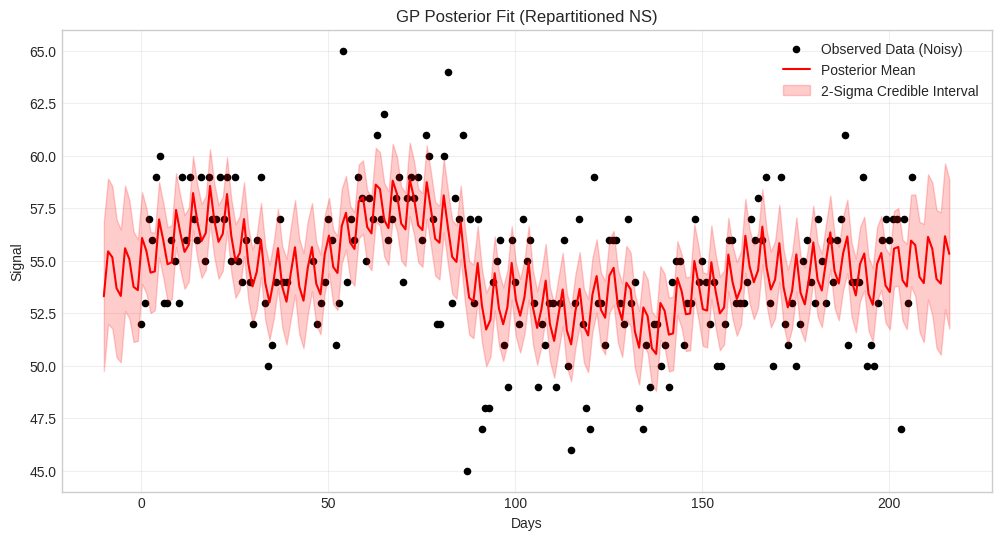

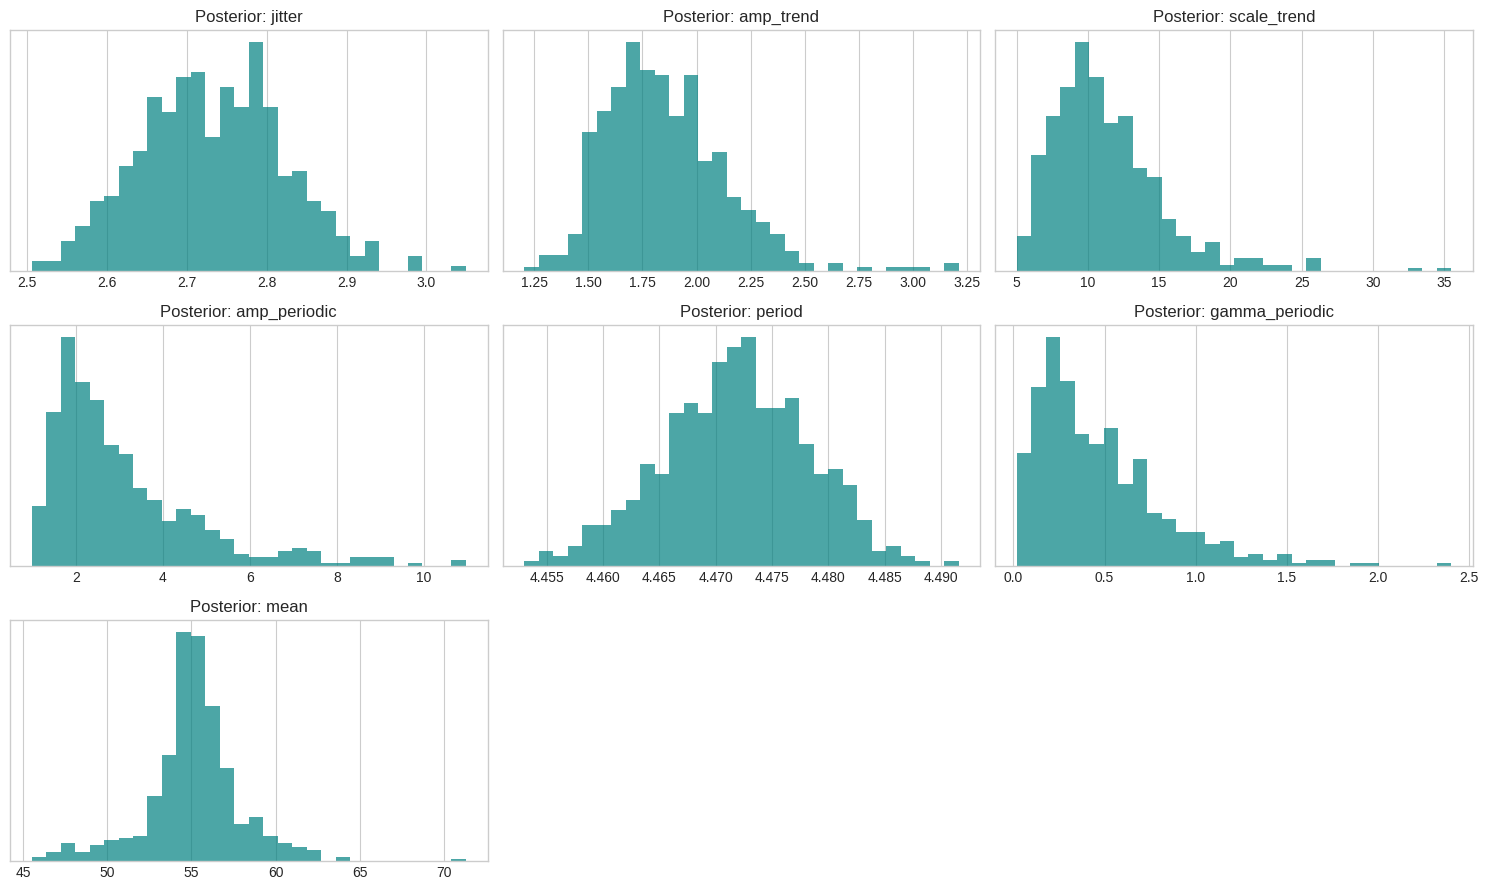

In [ ]:
# ==========================================
# 6. VISUALIZATION
# ==========================================
print("\n--- GENERATING PLOTS ---")

# 1. EXTRACT SAMPLES (Final Live Points)
# In a full run, you would combine dead_points + live_points weighted by volume.
# For a quick visual, the final live points are excellent samples of the core posterior.
flat_samples = state_2.particles
# flat_samples shape: (n_live, D)

# 2. HELPER: PREDICTION FUNCTION
# We need to turn flat parameters back into GP predictions
X_test = jnp.linspace(X.min() - 10, X.max() + 10, 200)

@jit
def get_gp_prediction(theta_flat):
    params = unravel_fn(theta_flat)

    # Reconstruct the GP with these specific parameters
    gp = build_gp(params, X)

    # Condition on the observed data (y)
    # strict=False allows computing covariance even if matrix is slightly ill-conditioned
    cond = gp.condition(y, X_test).gp

    return cond.loc, cond.variance

# 3. COMPUTE PREDICTIONS (Parallelized)
print("Computing GP predictions for visualization...")
# We pick a random subset of 100 samples to avoid cluttering the plot or running OOM
rng_key, plot_key = random.split(rng_key)
subset_indices = random.choice(plot_key, flat_samples.shape[0], shape=(100,), replace=False)
subset_samples = flat_samples[subset_indices]

# vmap over the samples to get 100 predictions at once
means, variances = vmap(get_gp_prediction)(subset_samples)
stds = jnp.sqrt(variances)

# 4. PLOT 1: GP FIT vs DATA
plt.figure(figsize=(12, 6))

# Plot Data
plt.scatter(X, y, c='k', s=20, label="Observed Data (Noisy)")

# Plot Model Uncertainty (The "Bands")
# We average the predictions of our samples
mean_pred = jnp.mean(means, axis=0)
std_pred = jnp.mean(stds, axis=0) # Approx avg sigma

plt.plot(X_test, mean_pred, 'r-', label="Posterior Mean")
plt.fill_between(X_test, mean_pred - 2*std_pred, mean_pred + 2*std_pred,
                 color='r', alpha=0.2, label="2-Sigma Credible Interval")

plt.xlabel("Days")
plt.ylabel("Signal")
plt.title("GP Posterior Fit (Repartitioned NS)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. PLOT 2: PARAMETER DISTRIBUTIONS
# We want to see if we recovered the period (~7.0) and other parameters.
# We transform back from log-space to physical space for readability.

params_pytree = vmap(unravel_fn)(flat_samples)

# Setup a grid of histograms
param_names = list(prior_params.keys())
n_params = len(param_names)
cols = 3
rows = (n_params + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))

for i, key in enumerate(param_names):
    plt.subplot(rows, cols, i+1)

    # Get values
    vals = params_pytree[key]

    # Transform back if it was logged in the prior definition
    # (Based on your prior_params structure)
    if "log_" in key:
        vals = jnp.exp(vals)
        title_key = key.replace("log_", "")
    else:
        title_key = key

    plt.hist(np.array(vals), bins=30, density=True, color='teal', alpha=0.7)

    # Add vertical line for "Truth" if known (approximate for this synthetic data)

    plt.title(f"Posterior: {title_key}")
    plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
!pip install anesthetic
import anesthetic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.9 MB/s eta 0:00:00


Processing Baseline samples...
Processing Repartitioned samples...
Generating Anesthetic plot for params: ['log_gamma_periodic', 'log_scale_trend', 'mean', 'log_amp_trend', 'log_period', 'log_amp_periodic', 'log_jitter']


RuntimeError: Triangulation is invalid

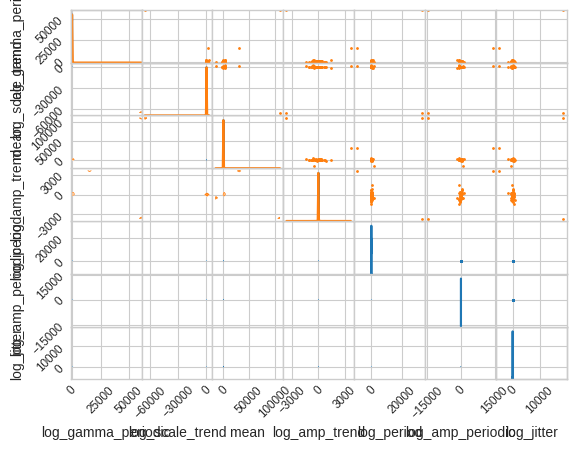

In [ ]:
import anesthetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def create_anesthetic_samples(dead_points_list, dead_logL_list, final_state, param_names, n_live):
    """
    Reconstructs an anesthetic.NestedSamples object from Blackjax tracking lists.
    Adds safety jitter to prevent 'Triangulation is invalid' errors.
    """
    # 1. Concatenate and Convert to NumPy
    dead_params = np.array(jnp.concatenate(dead_points_list))
    dead_logL = np.array(jnp.concatenate(dead_logL_list))

    live_params = np.array(final_state.particles)

    if hasattr(final_state, 'loglikelihood'):
        live_logL = np.array(final_state.loglikelihood)
    else:
        live_logL = np.array(final_state.log_likelihood)

    # 2. Combine
    all_params = np.concatenate([dead_params, live_params])
    all_logL = np.concatenate([dead_logL, live_logL])

    # 3. Create DataFrame
    data = pd.DataFrame(all_params, columns=param_names)
    data['logL'] = all_logL

    # 4. SAFETY JITTER (The Fix)
    # Add tiny noise to parameters to prevent collinearity/duplicate point errors in plotting
    # We apply 1e-5 relative to the spread of each parameter
    for col in param_names:
        std_val = data[col].std()
        if std_val == 0: std_val = 1.0 # Handle perfectly constant columns

        # Add noise: magnitude is 0.001% of the parameter's spread
        noise = np.random.normal(0, std_val * 1e-5, size=len(data))
        data[col] += noise

    # 5. Sort by Likelihood
    data = data.sort_values(by='logL').reset_index(drop=True)

    # 6. Create Object
    samples = anesthetic.NestedSamples(data=data, logL=data['logL'])
    samples.nlive = n_live

    return samples

# --- 1. Define Parameter Names ---
dummy_params = unravel_fn(flat_init)
param_names = list(dummy_params.keys())

# --- 2. Create Samples Objects ---
print("Processing Baseline samples...")
samples_baseline = create_anesthetic_samples(
    dead_points_list,
    dead_logL_list,
    state,
    param_names,
    n_live
)

print("Processing Repartitioned samples...")
samples_repart = create_anesthetic_samples(
    dead_points_repart,
    dead_logL_repart,
    state_2,
    param_names,
    n_live
)

# --- 3. CLEANING STEP ---
def drop_degenerate_columns(samples):
    """
    Drops columns that are constant or effectively discrete (too few unique values).
    """
    keep_cols = []
    dropped = []
    for col in param_names:
        if col in samples:
            # Check variance
            is_variable = samples[col].std() > 1e-9
            # Check unique values (triangulation needs at least 3 unique points)
            is_unique = len(samples[col].unique()) > 5

            if is_variable and is_unique:
                keep_cols.append(col)
            else:
                dropped.append(col)

    if dropped:
        print(f"WARNING: Dropping degenerate parameters: {dropped}")
    return keep_cols

valid_params_base = drop_degenerate_columns(samples_baseline)
valid_params_repart = drop_degenerate_columns(samples_repart)
plot_params = list(set(valid_params_base) & set(valid_params_repart))

if len(plot_params) == 0:
    print("Error: No parameters have sufficient variance to plot.")
else:
    # --- 4. Generate Comparison Plot ---
    print(f"Generating Anesthetic plot for params: {plot_params}")

    # Create figure and axes from the first plot
    # kind='kde' often works better than 'contour' for tight distributions,
    # but the default (usually kde/hist mix) should work with the jitter fix.
    axes = samples_baseline[plot_params].plot_2d(label="Baseline (Standard)")

    # Retrieve figure
    fig = plt.gcf()

    # Plot the repartitioned samples
    samples_repart[plot_params].plot_2d(axes, label="Guided (Student-t)")

    # Aesthetics
    plt.suptitle("Posterior Comparison: Standard vs Guided NS", fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# --- 5. Print Statistics ---
print("\n--- Statistics ---")
try:
    print(f"Baseline logZ:      {samples_baseline.logZ():.2f}")
    print(f"Repartitioned logZ: {samples_repart.logZ():.2f}")
except Exception as e:
    print(f"Stats calculation note: {e}")

In [ ]:
# --- 5. Visualize the Results ---
# This section remains unchanged, but we now use `posterior_samples` directly.
num_plot_samples = 100
rng_key, predict_key = jax.random.split(rng_key)
choice = jax.random.choice(predict_key, len(posterior_samples['knot_x']), shape=(num_plot_samples,))
plot_samples = {k: v[choice] for k, v in posterior_samples.items()}

X_plot = jnp.linspace(X.min(), X.max(), 500)

@jax.vmap
def predict(params):
    gp = build_gp(params, X)
    cond_gp = gp.condition(y, X_plot).gp
    # We need a new random key for each sample
    return cond_gp.sample(jax.random.PRNGKey(jnp.sum(params['knot_x']).astype(int)))

predictions = predict(plot_samples)


TypeError: JAX does not support string indexing; got idx=('knot_x',)

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import jit, vmap, random, value_and_grad, lax
from jax.scipy.special import logsumexp
from jax.flatten_util import ravel_pytree
import tinygp
import blackjax
from functools import partial
import tqdm
import matplotlib.pyplot as plt
import optax
import numpy as np

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# ==========================================
# 1. SETUP: DATA & MODEL
# ==========================================

rng_key = jax.random.PRNGKey(42)

start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
print(len(X))


y0, y1, x1 = y[0], y[-1], X[-1]


print(f"Data points: {len(X)}")

# --- GP Model Definition ---
def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(jnp.exp(params["log_scale_trend"]))
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]), gamma=jnp.exp(params["log_gamma_periodic"]))
    kernel = kernel_trend + kernel_periodic

    return tinygp.GaussianProcess(kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean=params['mean'])

prior_params = {
    "log_jitter": (-1.0, 1.0),
    "log_amp_trend": (0.0, 2.0),
    "log_scale_trend": (2.0, 2.0),
    "log_amp_periodic": (0.0, 2.0),
    "log_period": (2.0, 2.0), # centered on ~7.3 days
    "log_gamma_periodic": (0.0, 2.0),
    "mean": (50.0, 20.0) # Adjusted slightly for synthetic data
}

init_dummy = {k: v[0] for k, v in prior_params.items()}
flat_init, unravel_fn = ravel_pytree(init_dummy)
D = len(flat_init)

# ==========================================
# 2. BASE LOG PROBS
# ==========================================
t0 = time.time()

@jit
def log_likelihood_flat(theta_flat):
    params = unravel_fn(theta_flat)
    gp = build_gp(params, X)
    return gp.log_probability(y)

@jit
def log_prior_flat(theta_flat):
    params = unravel_fn(theta_flat)
    logp = 0.0
    for k, (loc, scale) in prior_params.items():
        logp += norm.logpdf(params[k], loc=loc, scale=scale)
    return logp

@jit
def log_posterior_total(theta):
    return log_likelihood_flat(theta) + log_prior_flat(theta)

# ==========================================
# 3. RUN 1: BASELINE (For Comparison)
# ==========================================
print("--- STARTING RUN 1: BASELINE ---")
# NOTE: This run is completely independent of the optimization run below.

n_live = 500
num_delete = n_live // 2
ns_algo = blackjax.nss(
    logprior_fn=log_prior_flat, loglikelihood_fn=log_likelihood_flat,
    num_delete=num_delete, num_inner_steps=D * 2
)

# Init Particles from Prior
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_live):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
              for i, (k, (loc, scale)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles_baseline = jnp.stack(init_particles_list)

state = ns_algo.init(initial_particles_baseline, log_likelihood_flat)
step_fn = jit(ns_algo.step)

# Run Loop
with tqdm.tqdm(desc="Baseline Run", unit=" dead") as pbar:
    while (state.logZ_live - state.logZ) > -3:
        rng_key, step_key = random.split(rng_key)
        state, info = step_fn(step_key, state)
        pbar.update(len(info.particles))

t_base = time.time() - t0
logZ_base = state.logZ
print(f"Baseline LogZ: {logZ_base:.2f} | Time: {t_base:.2f}s")


# ==========================================
# 4. PREPARATION FOR RUN 2: OPTIMIZATION
# ==========================================
print("\n--- PREPARING REPARTITIONED RUN (OPTIMIZATION) ---")
# We do NOT use results from Run 1. We start fresh from the Prior.

t_opt_start = time.time()

# 4a. Find Modes using Optimization
def find_modes_parallel(rng, n_candidates=100):
    # Sample random start points from the Prior
    starts = []
    for _ in range(n_candidates):
        rng, subk = random.split(rng)
        p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
                  for i, (k, (loc, scale)) in enumerate(prior_params.items())}
        starts.append(ravel_pytree(p_samp)[0])
    starts = jnp.stack(starts)

    optimizer = optax.adam(0.1)

    def optimize_single(start_pt):
        state = optimizer.init(start_pt)
        def step(c, _):
            p, s = c
            # Maximize Log Posterior
            grads = jax.grad(lambda x: -log_posterior_total(x))(p)
            updates, s = optimizer.update(grads, s)
            return (optax.apply_updates(p, updates), s), None
        (final_pt, _), _ = lax.scan(step, (start_pt, state), None, length=200)
        return final_pt

    candidates = vmap(optimize_single)(starts)

    # Filter for unique modes
    cands_np = np.array(candidates)
    scores = vmap(log_posterior_total)(candidates)

    # Sort by score
    sorted_idx = np.argsort(np.array(scores))[::-1]
    cands_np = cands_np[sorted_idx]

    # Simple Euclidean distance filter
    unique_modes = []
    for c in cands_np:
        if len(unique_modes) == 0: unique_modes.append(c)
        else:
            dists = np.linalg.norm(np.array(unique_modes) - c, axis=1)
            # Threshold: if further than 1.0 unit in parameter space
            if np.all(dists > 1.0): unique_modes.append(c)

    return jnp.array(unique_modes)

# 4b. Gaussian Mixture Helpers
def construct_gaussian_mixture(modes, hessians, inflation_factor=10.0):
    """
    Constructs Gaussian parameters directly from Optimization results.
    INFLATION is critical: We widen the covariance to ensure we cover the tails.
    """
    k = len(modes)

    def clean_precision(H):
        # 1. Eigen decomposition
        vals, vecs = jnp.linalg.eigh(-H) # H is usually neg-def at peak

        # 2. Clip small eigenvalues (flat directions)
        vals = jnp.maximum(vals, 1e-6)

        # 3. INFLATE: Divide curvature by factor -> Multiplies Variance
        vals = vals / inflation_factor

        # Reconstruct Precision Matrix
        return vecs @ jnp.diag(vals) @ vecs.T

    Ps = vmap(clean_precision)(hessians)

    # Uniform weights (since we don't know volume yet)
    weights = jnp.ones(k) / k

    return modes, Ps, weights

@jit
def log_prior_gaussian_mixture(theta, modes, Ps, weights):
    def gaussian_logpdf(mu, P, w):
        diff = theta - mu
        delta = jnp.sum((diff @ P) * diff)
        _, log_det = jnp.linalg.slogdet(P)
        # Log Normal PDF + Log Weight
        return -0.5 * (D * jnp.log(2 * jnp.pi) - log_det + delta) + jnp.log(w)

    return logsumexp(vmap(gaussian_logpdf)(modes, Ps, weights))

@partial(jit, static_argnums=(1,))
def sample_gaussian_mixture(key, n, modes, Ps, weights):
    k1, k2, k3 = random.split(key, 3)

    # 1. Select Component
    choices = random.choice(k1, len(weights), shape=(n,), p=weights)
    sel_mus = modes[choices]
    sel_Ps = Ps[choices]

    # 2. Sample Standard Normal
    z = random.normal(k2, shape=(n, D))

    # 3. Transform: x = mu + Chol(Cov) @ z
    # Cov = inv(P). We need L such that L L^T = Cov.
    covs = jnp.linalg.inv(sel_Ps)
    Ls = jnp.linalg.cholesky(covs)

    def trans(L, z_i): return L @ z_i
    return sel_mus + vmap(trans)(Ls, z)


# --- EXECUTE OPTIMIZATION ---

rng_key, k_fit = random.split(rng_key)
# 1. Find Modes
modes_fit = find_modes_parallel(k_fit, n_candidates=100)
print(f"   Found {len(modes_fit)} unique modes.")

# 2. Calculate Curvature (Hessian) at modes
hessians = vmap(jax.hessian(log_posterior_total))(modes_fit)

# 3. Construct Proposal (With Inflation)
# Factor 10.0 implies Standard Deviation is sqrt(10) ~ 3.16x wider than the Laplace approx.
Ps_fit, weights_fit = None, None
modes_fit, Ps_fit, weights_fit = construct_gaussian_mixture(modes_fit, hessians, inflation_factor=10.0)

t_optim = time.time() - t_opt_start
print(f"Optimization Time: {t_optim:.2f}s")


# ==========================================
# 5. RUN 2: REPARTITIONED (Gaussian Proposal)
# ==========================================
print("\n--- STARTING RUN 2: REPARTITIONED ---")

# 1. Sample new live points from the Gaussian Mixture
rng_key, subk = random.split(rng_key)
initial_particles_2 = sample_gaussian_mixture(subk, n_live, modes_fit, Ps_fit, weights_fit)
_ = initial_particles_2.block_until_ready() # Force computation

# 2. Define Repartitioned Likelihood
# L_new = L_old * (Prior_Old / Prior_New)
# log(L_new) = log(L_old) + log(Prior_Old) - log(Prior_New)

@jit
def log_prior_new(theta):
    return log_prior_gaussian_mixture(theta, modes_fit, Ps_fit, weights_fit)

@jit
def log_likelihood_repart(theta):
    ll = log_likelihood_flat(theta)
    lp_old = log_prior_flat(theta)
    lp_new = log_prior_new(theta)
    return ll + lp_old - lp_new

# 3. Setup Nested Sampling
# Note: We pass log_prior_new as the prior function to sample from!
ns_algo_repart = blackjax.nss(
    logprior_fn=log_prior_new,
    loglikelihood_fn=log_likelihood_repart,
    num_delete=num_delete, num_inner_steps=D # Often need fewer steps due to better geometry
)

state_2 = ns_algo_repart.init(initial_particles_2, log_likelihood_repart)
step_fn_2 = jit(ns_algo_repart.step)

t0_repart = time.time()

# 4. Run Loop
with tqdm.tqdm(desc="Repartitioned Run", unit=" dead") as pbar:
    while (state_2.logZ_live - state_2.logZ) > -3:
        rng_key, step_key = random.split(rng_key)
        state_2, info = step_fn_2(step_key, state_2)
        pbar.update(len(info.particles))

t_repart = time.time() - t0_repart
logZ_repart = state_2.logZ

print("\n=== RESULTS ===")
print(f"Baseline LogZ:      {logZ_base:.2f}")
print(f"Repartitioned LogZ: {logZ_repart:.2f}")
print(f"Baseline Time:      {t_base:.2f}s")
print(f"Optimization Time:  {t_optim:.2f}s")
print(f"Repartitioned Time: {t_repart:.2f}s")
print(f"Total Repart Time:  {t_optim + t_repart:.2f}s")
print(f"Speedup Factor:     {t_base / (t_optim + t_repart):.2f}x")

526
Data points: 526
--- STARTING RUN 1: BASELINE ---


Baseline Run: 8500 dead [02:09, 65.89 dead/s]


Baseline LogZ: -1345.50 | Time: 134.29s

--- PREPARING REPARTITIONED RUN (OPTIMIZATION) ---
   Found 87 unique modes.
Optimization Time: 13.16s

--- STARTING RUN 2: REPARTITIONED ---


Repartitioned Run: 8250 dead [01:08, 120.90 dead/s]


=== RESULTS ===
Baseline LogZ:      -1345.50
Repartitioned LogZ: -1345.19
Baseline Time:      134.29s
Optimization Time:  13.16s
Repartitioned Time: 68.24s
Total Repart Time:  81.40s
Speedup Factor:     1.65x


In [ ]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
import tinygp
import blackjax
from blackjax.ns.utils import finalise # Utility for processing results
import matplotlib.pyplot as plt
from functools import partial
import tqdm # For a nice progress bar

# Enable 64-bit precision for more stable computations
jax.config.update("jax_enable_x64", True)


rng_key = jax.random.PRNGKey(42)
rng_key, data_key = jax.random.split(rng_key)
start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
y0 = y[0]
y1 = y[-1]
x1 = X[-1]
def flexknot(params, X):
  seg1 = X*jnp.where(X<=params['knot_x'],(params['knot_y']-y0)/params['knot_x'],0)+jnp.where(X<=params['knot_x'],0,(params['knot_y']-y0))
  seg2=(X-params['knot_x'])*jnp.where(X<=params['knot_x2'],(params['knot_y2']-params['knot_y'])/(params['knot_x2']-params['knot_x']),0)+jnp.where(X<=params['knot_x2'],0,(params['knot_y2']-params['knot_y']))
  seg3 = (X-params['knot_x2'])*jnp.where(X<=params['knot_x3'],(params['knot_y3']-params['knot_y2'])/(params['knot_x3']-params['knot_x2']),0)+jnp.where(X<=params['knot_x3'],0,(params['knot_y3']-params['knot_y2']))
  seg4 = (X-params['knot_x3'])*jnp.where(X<=params['knot_x3'],0,(y1-params['knot_y3'])/(x1-params['knot_x3']))

  return y0+seg1+seg2+seg3+seg4




# --- 2. Define the GP Model with tinygp ---
# This section remains unchanged
def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(
        jnp.exp(params["log_scale_trend"])
    )
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]),
        gamma=jnp.exp(params["log_gamma_periodic"])
    )
    kernel = kernel_trend + kernel_periodic


    return tinygp.GaussianProcess(
        kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean=partial(flexknot,params)
    )

# --- 3. Define Priors and Likelihood using only JAX ---
# This section remains unchanged
prior_params = {
    "log_jitter": (-1.0, 1.0),
    "log_amp_trend": (0.0, 2.0),
    "log_scale_trend": (2.0, 2.0),
    "log_amp_periodic": (0.0, 2.0),
    "log_period": (2.0, 2.0),
    "log_gamma_periodic": (0.0, 2.0),
    "knot_x": (150.0, 100.0),
    "knot_y": (60.0, 50.0),
    "knot_x2": (250.0, 100.0),
    "knot_y2": (60.0, 50.0),
    "knot_x3": (450.0, 100.0),
    "knot_y3": (60.0, 50.0),

}

paranames = list(prior_params.keys())


def log_prior_fn(params_dict):
    return jnp.sum(
        jnp.array([
            norm.logpdf(params_dict[k], loc=loc, scale=scale)
            for k, (loc, scale) in prior_params.items()
        ])
    )

def log_likelihood_fn(params_dict, X, y):
    gp = build_gp(params_dict, X)
    return gp.log_probability(y)

# --- 4. Run Nested Sampling with the Correct blackjax API ---
# This is the section that has been updated.





In [ ]:
num_live_points = 500
log_likelihood = partial(log_likelihood_fn, X=X, y=y)

# Initialize the nested sampling algorithm object
# `blackjax.nss` is the new top-level API for this sampler.
ns_algorithm = blackjax.nss(
    logprior_fn=log_prior_fn,
    loglikelihood_fn=log_likelihood,
    num_delete = 60,
    num_inner_steps=2  # Steps to take to find a new point
)

# Manually draw initial samples from the prior distributions as a dictionary
rng_key, init_key = jax.random.split(rng_key)
keys = jax.random.split(init_key, len(prior_params))
initial_params_dict = {}
for i, (k, (loc, scale)) in enumerate(prior_params.items()):
    initial_params_dict[k] = loc + scale * jax.random.normal(keys[i], (num_live_points,))

# Initialize the sampler state
rng_key, init_alg_key = jax.random.split(rng_key)
initial_state = ns_algorithm.init(initial_params_dict, init_alg_key)

# Define the step function and jit-compile it for speed
@jax.jit
def step(rng_key, state):
    return ns_algorithm.step(rng_key, state)

# Run the nested sampling loop
dead_points = []
pbar = tqdm.tqdm(desc="Nested Sampling", unit=" dead points")
while (initial_state.logZ_live - initial_state.logZ) > -3: # A common stopping condition
    rng_key, step_key = jax.random.split(rng_key)
    initial_state, dead = step(step_key, initial_state)
    dead_points.append(dead)
    pbar.update(len(dead.particles['log_jitter'])) # Update progress bar
pbar.close()

# Combine the final live points with the dead points to get the full run
ns_run = finalise(initial_state, dead_points)
posterior_samples = ns_run.particles



Nested Sampling: 3360 dead points [01:28, 37.89 dead points/s]


KeyboardInterrupt: 

In [ ]:
log_evidence = initial_state.logZ_live
print(f"Log Evidence: {log_evidence}")

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(X_plot, predictions.T, color="C0", alpha=0.1)
plt.plot(X, y, "ok", label="Data")
plt.plot(X,flexknot(mean_params,X))
mu = jnp.mean(predictions, axis=0)
percentiles = jnp.percentile(predictions, jnp.array([2.5, 97.5]), axis=0)
plt.plot(X_plot, mu, color="C1", label="Posterior Mean")
plt.fill_between(X_plot, percentiles[0], percentiles[1], color='C1', alpha=0.3, label="95% CI")
plt.xlabel("Days")
plt.ylabel("Resting Heart Rate")
plt.title("Gaussian Process Fit with tinygp and blackjax.nss")
plt.legend()
plt.show()